<a href="https://www.kaggle.com/code/candacevogel/celeba-dataset-candace-vogel?scriptVersionId=263060236" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CelebA Glasses Facial Characteristic Recognition

In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.v2 as transforms
from torchvision.transforms import ToTensor
from torchvision import datasets

from os import path
from PIL import Image

In [2]:
# Load data - create path to files

In [3]:
dataset_root = '/kaggle/input/celeba-dataset'

# input data from dataset

image_path = path.join(dataset_root, 'img_align_celeba/img_align_celeba')
# image_path contains the jpg files
attributes_path = path.join(dataset_root, 'list_attr_celeba.csv')
# file path for the csv file containing the attributes

# Read attributes CSV

In [4]:
df_attributes = pd.read_csv(attributes_path)
df_attributes.head()
# dataframe (df) is a type of table that panda library uses
# read csv file using pandas library ^
df_attributes.replace(-1, 0, inplace=True)
df_attributes['Eyeglasses'].head()

# this output will print just the eyeglasses data

0    0
1    0
2    0
3    0
4    0
Name: Eyeglasses, dtype: int64

In [5]:
# Replace -1 with 0

In [6]:

df_attributes.replace(-1, 0, inplace=True)
# 1 is true / represents wearing glasses
# 0 is false / represents not wearing glasses
# replaces every instance of -1 with 0
# now the data is all 0s and 1s
df_attributes['Eyeglasses'].head()
# prints just eyeglasses attributes column

0    0
1    0
2    0
3    0
4    0
Name: Eyeglasses, dtype: int64

# How many people are wearing glasses?

In [7]:
df_attributes['Eyeglasses'].value_counts()
# prints number of people wearing glasses in dataset

Eyeglasses
0    189406
1     13193
Name: count, dtype: int64

# Balance dataset

In [8]:
glasses_df = df_attributes [ df_attributes ['Eyeglasses'] == 1]
no_glasses_df = df_attributes [ df_attributes['Eyeglasses'] == 0]
# filtering attributes for glasses and no glasses

len(glasses_df), len(no_glasses_df)
# prints how many people are wearing glasses vs no glasses
glasses_count = len(glasses_df)
# prints how many people have glasses 
no_glasses_same_size = no_glasses_df.sample(glasses_count)
# sample is pandas method (pick rows at random)
len(no_glasses_same_size)
# prints how many people don't wear glasses in dataset
df_glasses_training = pd.concat ( [glasses_df, no_glasses_same_size], axis=0 )
# concatenate variables onto row axis
# axis=0 stacks tables vertically
# df_glasses_training is our balanced dataset
# the data is normalized so there is an equal number of images for glasses vs no glasses
# len(df_glasses_training)

df_glasses = df_glasses_training[['image_id','Eyeglasses']].sample(10)
#display 10 rows at random
df_glasses.sample(10)
#only prints attributes we care about - normalized eyeglasses data

,image_id,Eyeglasses
186098,186099.jpg,0
101764,101765.jpg,1
200930,200931.jpg,1
80074,080075.jpg,1
135040,135041.jpg,1
200367,200368.jpg,1
192038,192039.jpg,0
168028,168029.jpg,1
140915,140916.jpg,0
9873,009874.jpg,1


# Create a Dataset Class

In [9]:
class CelebDataset(Dataset):
    def __init__(self, images_path, attributes_dataframe, img_transform=None, attr_transform=None):
        self.images_path = images_path
        self.attributes_dataframe = attributes_dataframe
        self.img_transform = img_transform
        self.attr_transform = attr_transform
        self.image_filename = attributes_dataframe['image_id'].tolist()

    def __getitem__(self, index):
        # return the image and its label that are in position (index) in the dataset
        image_filename = self.image_filename[index]
        image_path = path.join(self.images_path, image_filename)
        img = Image.open(image_path).convert('L')
        # convert is PIL function - grayscale images require less storage

        attributes = self.attributes_dataframe.iloc[index]
        glasses = attributes.Eyeglasses.astype('int')
        # need to process data before we send to NN 
        # if img_transform is provided...
        
        if self.img_transform:
            img = self.img_transform(img)
            # call img_transform function

        if self.attr_transform:
            glasses = self.attr_transform(glasses)
            # not used, butmay be useful in another situation

        return img, glasses

    def __len__(self):
        return len(self.attributes_dataframe)
        

        

# Define image transformations

In [10]:
image_size = 128

image_transform = transforms.Compose([
    transforms.Resize(image_size),
    # resizes on the shorter edge
    transforms.CenterCrop( [image_size, image_size] ),
    ToTensor(),
])

dataset = CelebDataset(image_path, df_glasses, image_transform)

# Divide dataset into training and test data

In [11]:
train_dataset, test_dataset = random_split(dataset, (0.8, 0.2) )

# Create dataloaders for train and test datasets

In [12]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Visualize example images

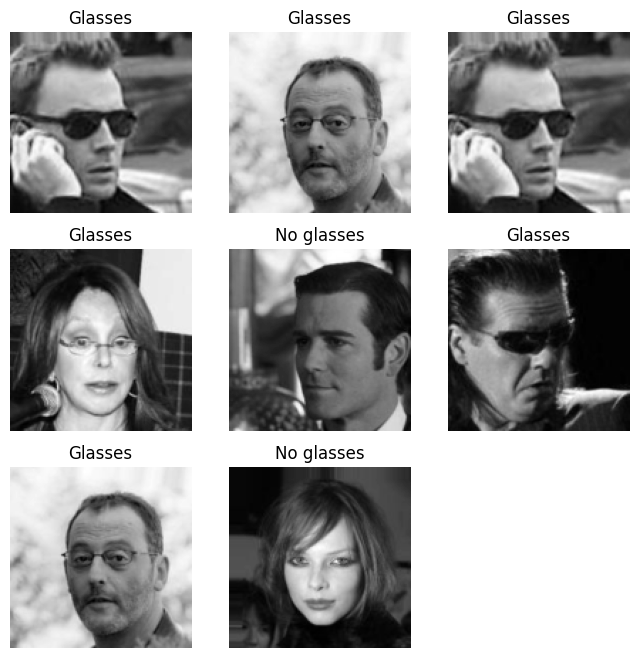

In [13]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8,8))
cols = 3
rows = 3
for i in range(1, cols * rows):
    sample_index = torch.randint(len(train_dataset), size=(1, )).item()
    img, label = train_dataset[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.title('Glasses' if label == 1 else 'No glasses')
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')

plt.show()

